# HOMEWORK 13

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from collections import Counter


# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


<ipython-input-2-6503938aa8d6>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


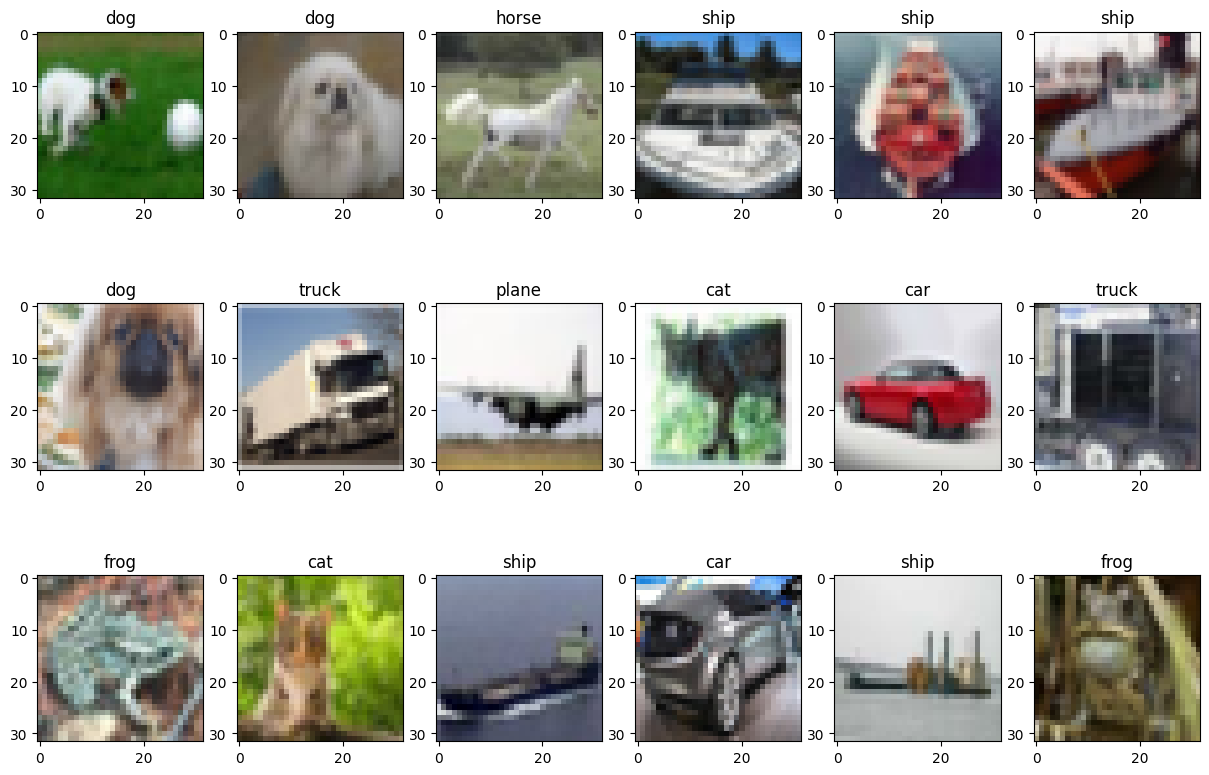

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

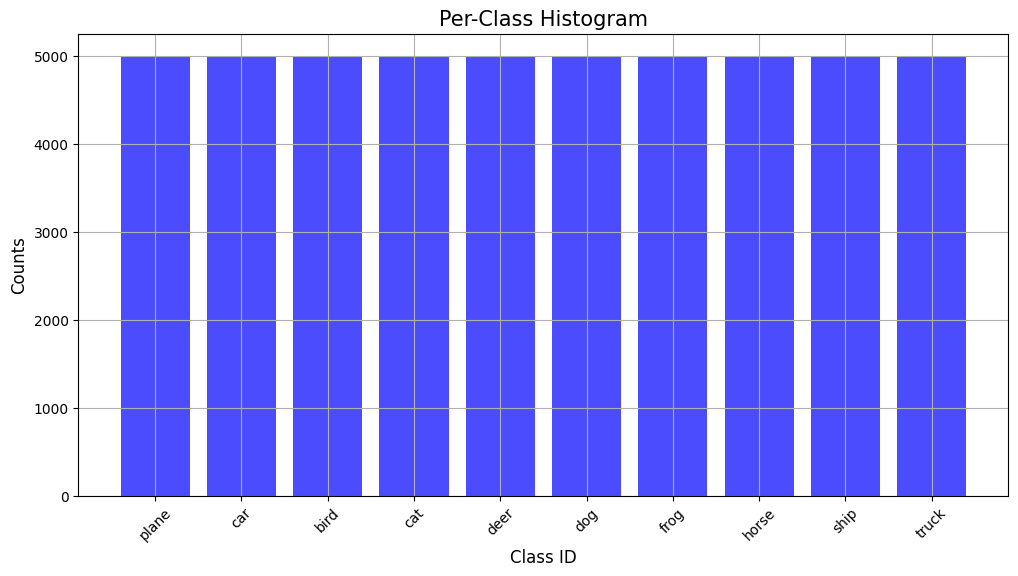

In [9]:
# Compute the class histogram
hist = Counter(y_train.flatten())


# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(hist.keys(), hist.values(), color='blue', alpha=0.7)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Per-Class Histogram', fontsize=15)
plt.xticks(range(num_classes), [classes[i] for i in range(num_classes)], rotation=45)

plt.grid(True)
plt.show()

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [10]:
# Normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [11]:
# Build the classifier
model = tf.keras.Sequential([
    Input(shape=(32, 32, 3)),  # CIFAR-10 image dimensions
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with 10 classes
])

# Show the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [15]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1 )

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 180ms/step - accuracy: 0.3188 - loss: 1.8747 - val_accuracy: 0.5159 - val_loss: 1.3865
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.5297 - loss: 1.3297 - val_accuracy: 0.5704 - val_loss: 1.2422
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.5907 - loss: 1.1736 - val_accuracy: 0.6157 - val_loss: 1.1184
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 161ms/step - accuracy: 0.6279 - loss: 1.0642 - val_accuracy: 0.6329 - val_loss: 1.0614
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 172ms/step - accuracy: 0.6558 - loss: 0.9883 - val_accuracy: 0.6451 - val_loss: 1.0357
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 168ms/step - accuracy: 0.6789 - loss: 0.9274 - val_accuracy: 0.6531 - val_loss: 1.0106
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.6967 - loss: 0.8786 - val_accuracy: 0.6597 - val_loss: 0.9946
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.7154 - loss: 0

Train Acc      0.8738750219345093
Validation Acc 0.6593000292778015


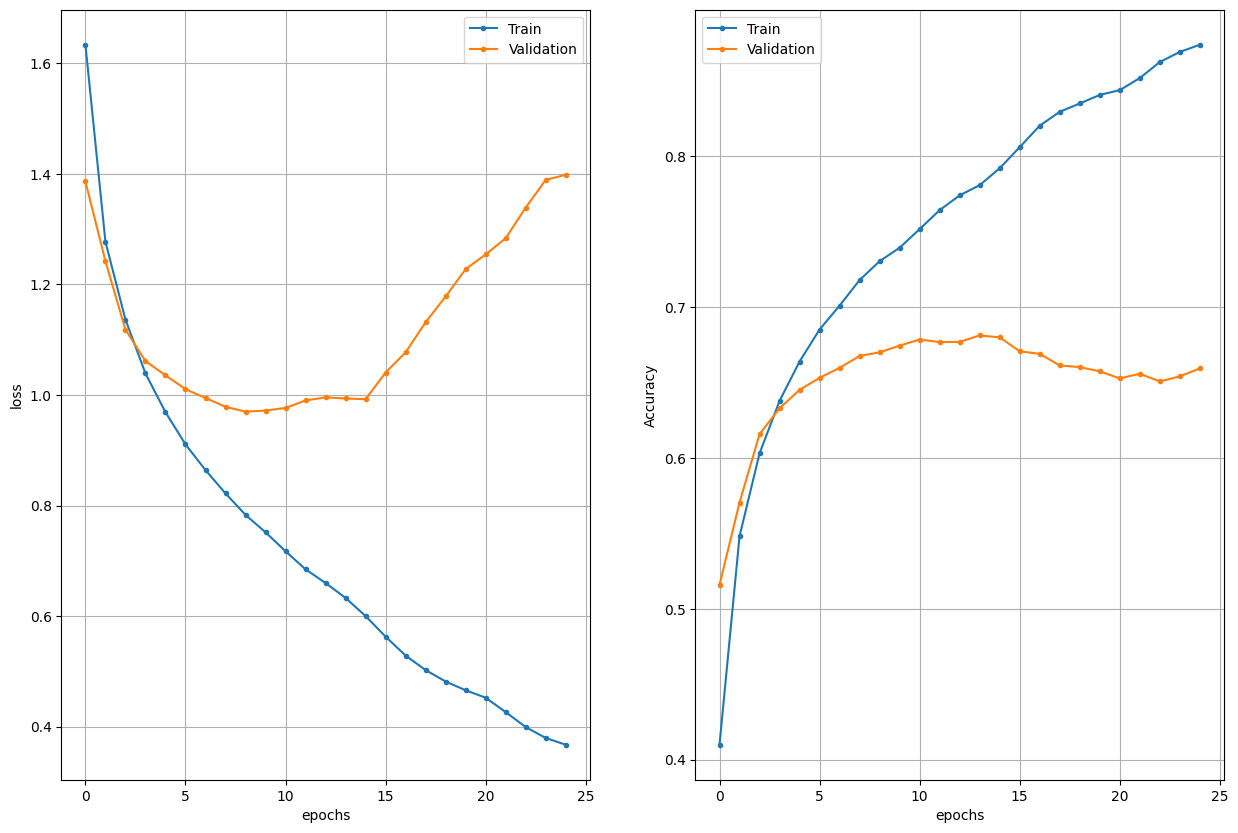

In [16]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [17]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [18]:
# Compute and print the accuracy for each class
for class_id, class_name in classes.items():
    class_indices = np.where(y_true == class_id)[0]
    class_accuracy = np.sum(y_pred[class_indices] == y_true[class_indices]) / len(class_indices)
    print(f"{class_name}: {class_accuracy:.2f}")

plane: 0.67
car: 0.77
bird: 0.56
cat: 0.33
deer: 0.53
dog: 0.61
frog: 0.74
horse: 0.74
ship: 0.87
truck: 0.71


In [19]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6526 - loss: 1.4005
Test loss   1.4166525602340698
Test metric 0.652999997138977


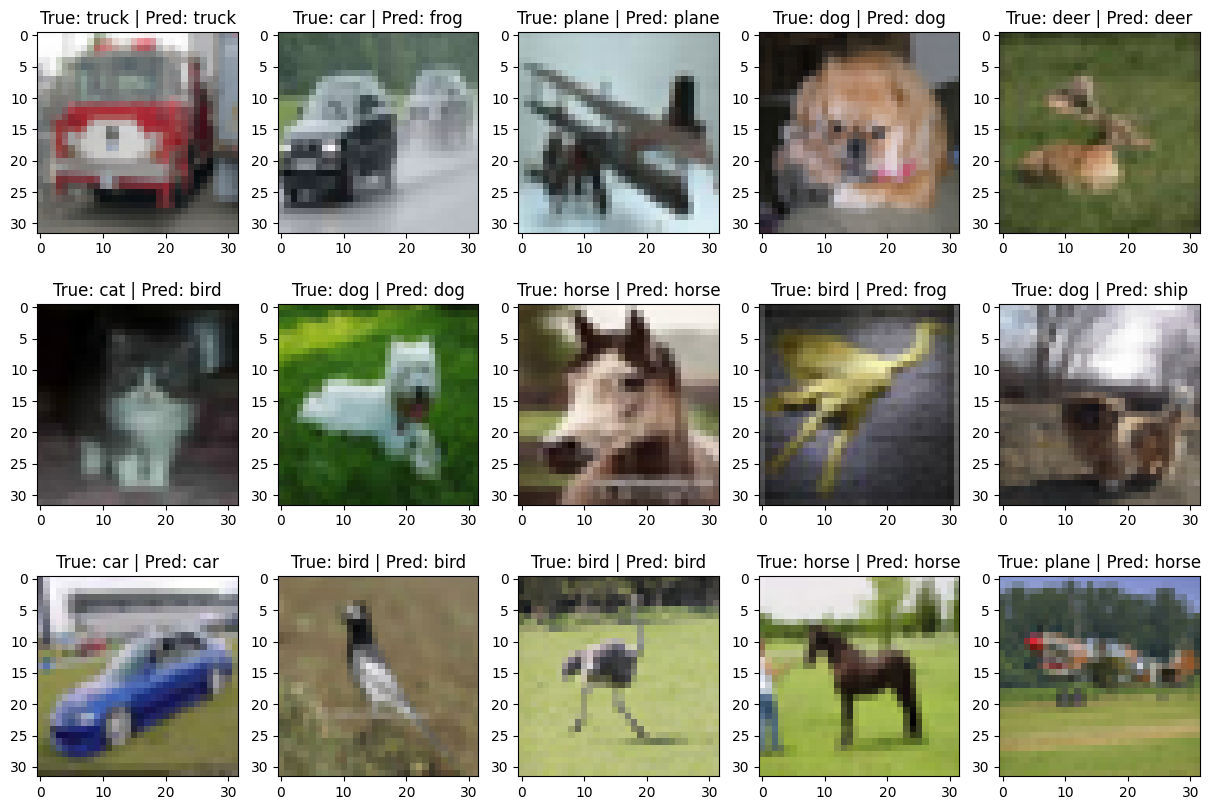

In [20]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?


Test metric above shows the accuracy - it is 0.65
* What modifications would you do in order to improve the classification accuracy?

For example to add more layers or increase the number of filters in model training step.
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

I didnt manage to make it done on time, sorry(

